<a href="https://colab.research.google.com/github/shearere2/fall_2024_transit/blob/main/TransitFinalCodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DEA

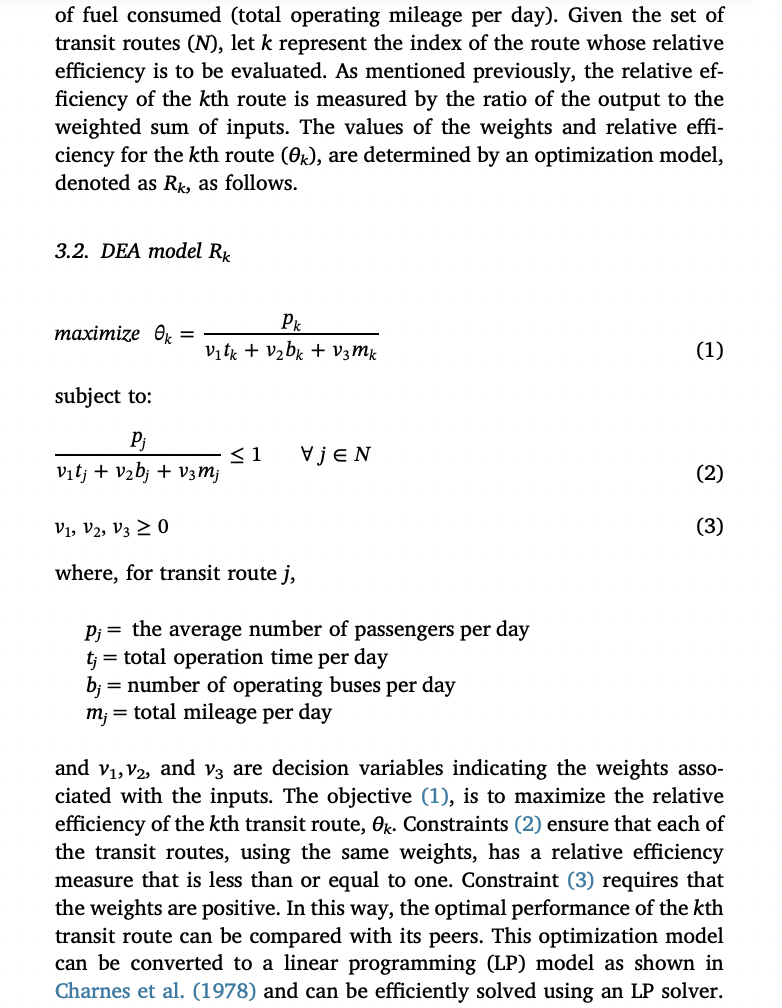

Add efficiency to route dataframe

In [8]:
import pandas as pd

# Used for DEA (data envelopment analysis)

# RIDERSHIP DATA -- Used for p_j (avg number of daily passengers for each route)
ridership = pd.read_csv('ridership_by_route.csv')
avg_daily_riders = ridership.groupby('route')['avg_riders'].mean().sort_values(ascending=False).reset_index()

# SCHEDULE DATA -- Used for t_j (avg operating time per day) and m_j (avg milage
# per day)
schedule = pd.read_csv('schedule_daily_agg.csv')

# Raw schedule contains daily sums for list of days. In order to get a daily
# averages for milage and time for all days listed, must group the data by
# route, and then take the mean for the respective data columns' mileage or time
avg_total_mileage_per_day = schedule.groupby('RouteCode')['Trp.Dist.'].mean().sort_values(ascending=False).reset_index()
avg_total_operation_mins_per_day = schedule.groupby('RouteCode')['Trip_Mins'].mean().sort_values(ascending=False).reset_index()

# VEHICLES PER DAY DATA -- Self-collected on September 10, 2024. Used for b_j
# (avg operating vehicles per day per route)
avg_operating_vehicles_per_day = pd.read_csv('vehicles_per_route_estimates.csv')

# THIS SECTION VERY SPECIFIC TO THE DATA CURRENTLY USED
avg_daily_riders.rename(columns={'route': 'Route'}, inplace=True)
avg_total_mileage_per_day.rename(columns={'RouteCode': 'Route'}, inplace=True)
avg_total_operation_mins_per_day.rename(columns={'RouteCode':'Route'}, inplace=True)

# Creating the merged dataset to have p_j, m_j, t_j, b_j all in one place
route_data = pd.merge(avg_daily_riders, avg_total_mileage_per_day, on='Route')
route_data = pd.merge(route_data, avg_total_operation_mins_per_day, on='Route')
route_data = pd.merge(route_data, avg_operating_vehicles_per_day, on='Route')

from scipy.optimize import linprog

A_ub = []
b_ub = []
for index, row in route_data.iterrows():
  A_ub.append([-row['Trip_Mins'], -row['num_vehicles'], -row['Trp.Dist.']])
  b_ub.append(-row['avg_riders'])


route_data = pd.concat([route_data, pd.DataFrame({'Route':'FAKE', 'avg_riders':45, 'Trp.Dist.':2774,
                   'Trip_Mins':12345.67, 'num_vehicles':3}, index=[93])], ignore_index=True)

results = []

v1_bounds = (0, None)
v2_bounds = (0, None)
v3_bounds = (0, None)
bounds = [v1_bounds, v2_bounds, v3_bounds]

for index, row in route_data.iterrows():

  p_k = row['avg_riders']
  t_k = row['Trip_Mins']
  b_k = row['num_vehicles']
  m_k = row['Trp.Dist.']

  result = linprog(c=[t_k/p_k, b_k/p_k, m_k/p_k], A_ub=A_ub, b_ub=b_ub, bounds=bounds)
  results.append(1/result.fun) # Efficiency


route_data['operational_efficiency'] = results
route_data.sort_values(by='operational_efficiency').tail(10)
route_data = route_data.rename(columns={'Route':'ROUTE'})
route_data = route_data.set_index('ROUTE')

<ipython-input-8-27ab729c8d74>:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  schedule = pd.read_csv('schedule_daily_agg.csv')


Visualize Routes

In [9]:
!pip install folium
import folium
import numpy as np
import geopandas as gpd

routes = gpd.read_file('paac_routes_1909 (1).zip')
routes = routes.set_index('ROUTE')

order = routes.index.to_list()
routes['efficiency'] = route_data[['operational_efficiency']].reindex(order)

routes['geometry'] = routes['geometry'].to_crs(4326)
cbg = gpd.read_file('allegheny_cbg.zip')
cbg['geometry'] = cbg['geometry'].to_crs(4326)

# Build the initial folium map centered in Pittsburgh
m = folium.Map(location=[40.4406, -79.996], zoom_start=11,
               tiles="Cartodbdark_matter",width="100",weight="100")

# Loop through each bus route
for index, row in routes.iterrows():

  # Get coordinates for bus route geometry
  try: coordinates = list(row['geometry'].coords)
  except: pass

  # Invert coordinates (Folium likes lat, lon whereas shapely likes lon, lat)
  for i in range(len(coordinates)):
    coordinates[i] = (coordinates[i][1], coordinates[i][0])

  # Set route colors based on efficiency
  if row['efficiency'] >=0 and row['efficiency'] <=0.4: color = 'red'
  elif row['efficiency'] > 0.4 and row['efficiency'] <= 0.7: color = 'yellow'
  else: color = 'green'

  # Create line
  my_PolyLine=folium.PolyLine(locations=coordinates, color=color, weight=2)

  # Add line to map
  m.add_child(my_PolyLine)

# Output map
m

Pittsburgh Regional Transit bus route operational efficiencies visualized